# 2. Data Exploration
This notebook is dedicated to exploring the dataset in detail to uncover insights and patterns that can guide further data processing and model building. We'll focus on understanding the distribution and relationships among various features related to hotel bookings. Key areas of exploration include:
1. Distribution Analysis: Analyzing the distributions of different variables to understand the spread and central tendencies within our data. This will help in identifying outliers and anomalies.
2. Feature Relationships: Exploring the relationships between different features using visualizations and statistical measures to identify potential predictors of cancellation.
3. Categorical and Numerical Analysis: Separately analyzing categorical and numerical features to understand their individual impact on the likelihood of a booking being cancelled.
4. Correlation Analysis: Examining the correlations between features to detect multicollinearity which might affect model performance.
5. Temporal Trends: Observing how booking patterns and cancellation rates vary over time to identify any seasonal effects.
The insights gathered from this analysis will be instrumental in shaping our data preprocessing strategies and building robust predictive models.

## Import Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score

## Import data

In [2]:
df = pd.read_csv('Data/cleaned.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36238 entries, 0 to 36237
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36238 non-null  object 
 1   no_of_adults                          36238 non-null  int64  
 2   no_of_children                        36238 non-null  int64  
 3   no_of_weekend_nights                  36238 non-null  int64  
 4   no_of_week_nights                     36238 non-null  int64  
 5   type_of_meal_plan                     36238 non-null  object 
 6   required_car_parking_space            36238 non-null  int64  
 7   room_type_reserved                    36238 non-null  object 
 8   lead_time                             36238 non-null  int64  
 9   arrival_year                          36238 non-null  int64  
 10  arrival_month                         36238 non-null  int64  
 11  arrival_date   

Looking at the column features, the data types are either numeric or of object type. Lets first split the columns into its types and explore them individually.

Note: Booking ID will not be useful in our analysis and prediction as it is an assigned value, hence we will first drop it

In [6]:
df = df.drop("Booking_ID", axis=1)

In [11]:
# Initialize empty lists to hold column names for each data type
num_columns = []
cat_columns = []

# Iterate over each column and classify it by its data type
for column, dtype in df.dtypes.items():
    if dtype == 'object':
        cat_columns.append(column)
    elif column in ['required_car_parking_space', 'repeated_guest']:
        cat_columns.append(column)
    else:
        num_columns.append(column)

In [12]:
print("Numerical Columns: ",  num_columns)
print("Categorical Columns: ", cat_columns)

Numerical Columns:  ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
Categorical Columns:  ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type', 'repeated_guest', 'booking_status']


## Analyse Numerical Columns

To analyze the distribution of numerical columns for cancelled and non-cancelled bookings, we'll plot the distributions of these two groups to compare how each feature varies between them. This approach will help us identify which factors are more closely associated with the likelihood of a booking being cancelled. We will utilize distribution plots and kernel density estimate (KDE) plots for comparison. 

KDE is a method for visualizing the distribution of observations in a dataset, resembling the underlying probability density function for a given variable. By using KDE, we can produce smoother distributions that better represent the data, making it easier to spot differences and trends between cancelled and non-cancelled bookings.

In [7]:
sns.set_style("whitegrid")

In [3]:
def custom_displot(x_column_name):
    # Plot the displot for each group
    sns.displot(data=df, x=x_column_name, hue='booking_status', discrete=True, height=4, aspect=1.5)
    plt.title(f'Relationship between {x_column_name} and Booking Status')
    plt.show()
    
def custom_heatmap(x_column_name):
    crosstab = pd.crosstab(df['booking_status'], df[x_column_name])
    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt='g')
    # Set the title
    plt.title(f'Relationship between Booking Status and {x_column_name}')
    # Show the plot
    plt.show()

def custom_KDE(x_column_name):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))
    # Plot the kernel density estimate (KDE) for each group
    sns.kdeplot(data=df, x=x_column_name, hue='booking_status', ax=ax, fill=True)
    # Set the title
    ax.set_title(f'Relationship between {x_column_name} and Booking Status')
    # Show the plot
    plt.show()

### Number of people

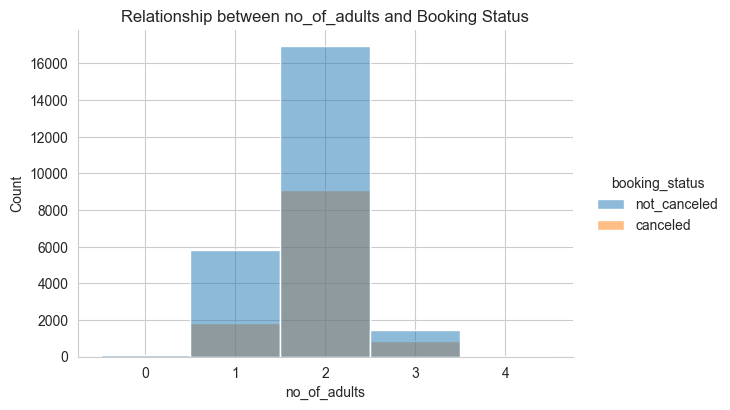

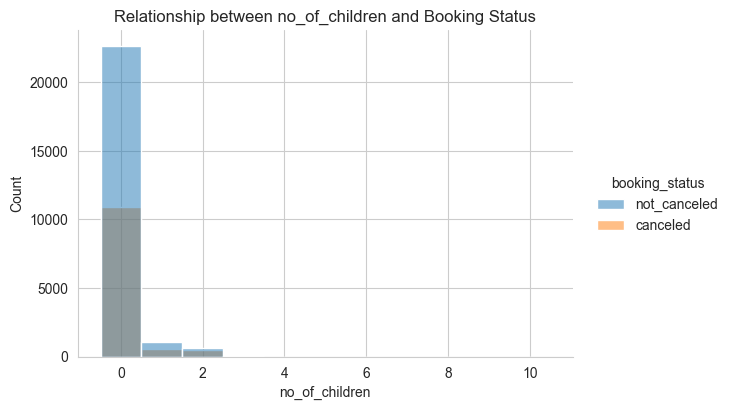

In [9]:
custom_displot('no_of_adults')
custom_displot('no_of_children')

The density for not-cancelled bookings with two adults is noticeably higher than for cancelled bookings, suggesting that bookings for two adults are less likely to be cancelled than other group sizes.

The density for not-cancelled bookings without children is higher than for cancelled bookings, suggesting that bookings without children are less likely to be cancelled.

### Number of nights

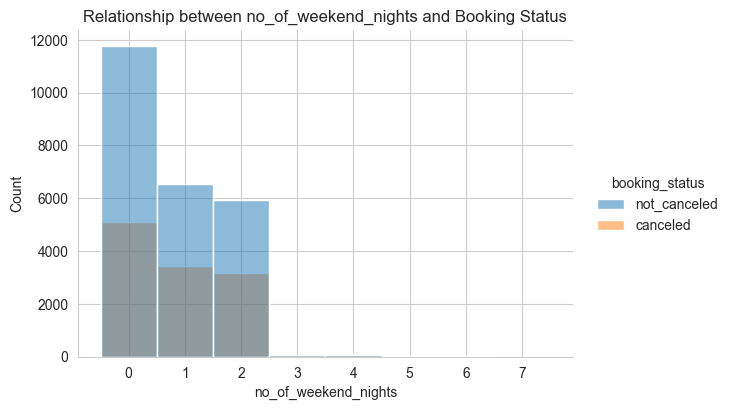

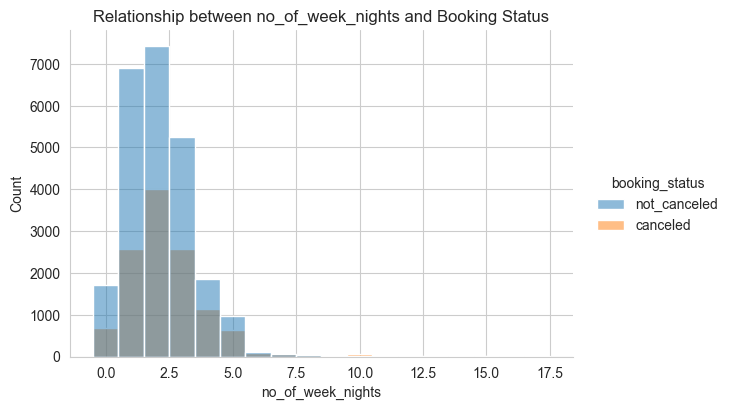

In [10]:
custom_displot('no_of_weekend_nights')
custom_displot('no_of_week_nights')

Bookings that include one or two weekend nights are less likely to be cancelled compared to those with no weekend nights, and the likelihood of cancellation decreases as the number of weekend nights included in the booking increases up to two nights.

### Arrival Dates

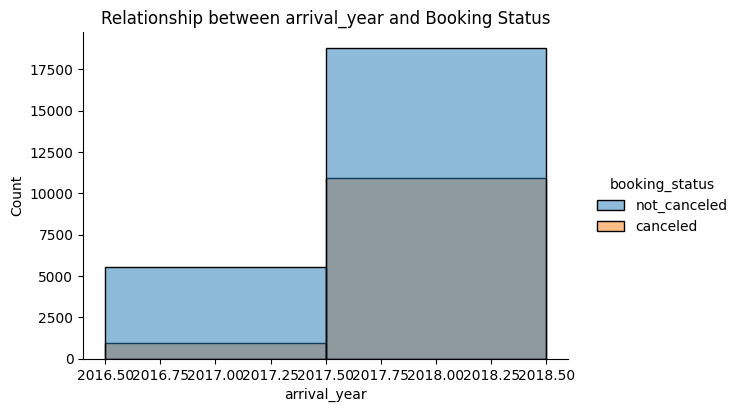

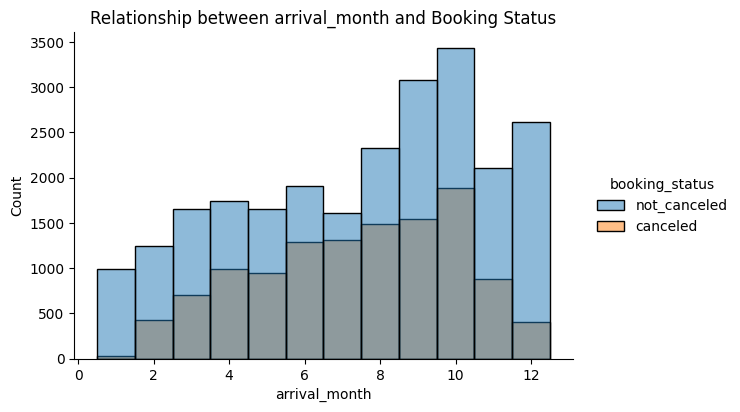

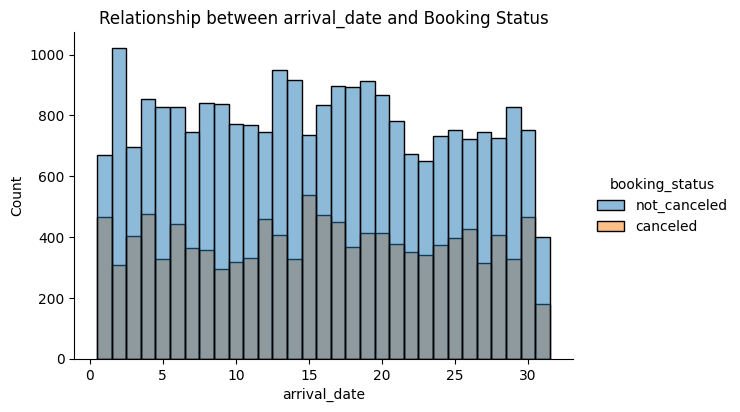

In [14]:
custom_displot('arrival_year')
custom_displot('arrival_month')
custom_displot('arrival_date')

The number of cancellations proportional to the total number of bookings increases from February to July. 
The proportion of cancellations are the lowest in December and January, possibly due to winter holidays.

The relative probabilites of cancellation vary throughout the year and within a month, indicating date could be a good estimator. It is also evident that hotel cancellation rates in December and January are notably lower compared to other months of the year. This phenomenon may be attributed to the heightened demand for hotel rooms during the winter holidays, making it challenging for customers to secure accommodations. Consequently, customers are less inclined to cancel their reservations during this period.

### Number of historic cancellations

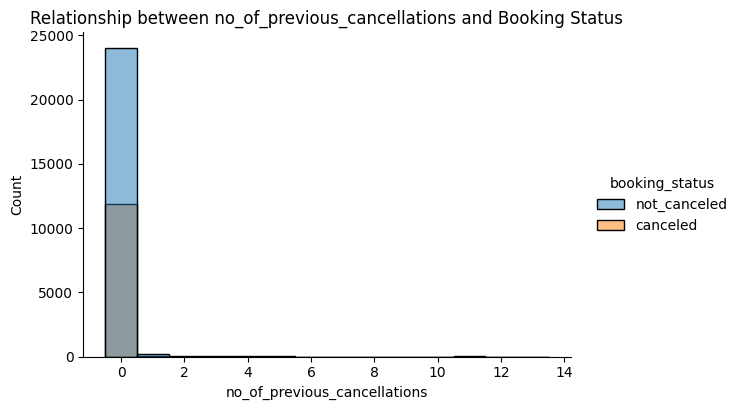

In [13]:
custom_displot('no_of_previous_cancellations')

In [17]:
column_name = 'no_of_previous_bookings_not_canceled'
filtered_df = df[df[column_name] == 0]
status_counts = filtered_df['booking_status'].value_counts(normalize=True)
status_probability = status_counts * 100

print(status_probability)

not_canceled    66.49355
canceled        33.50645
Name: booking_status, dtype: float64


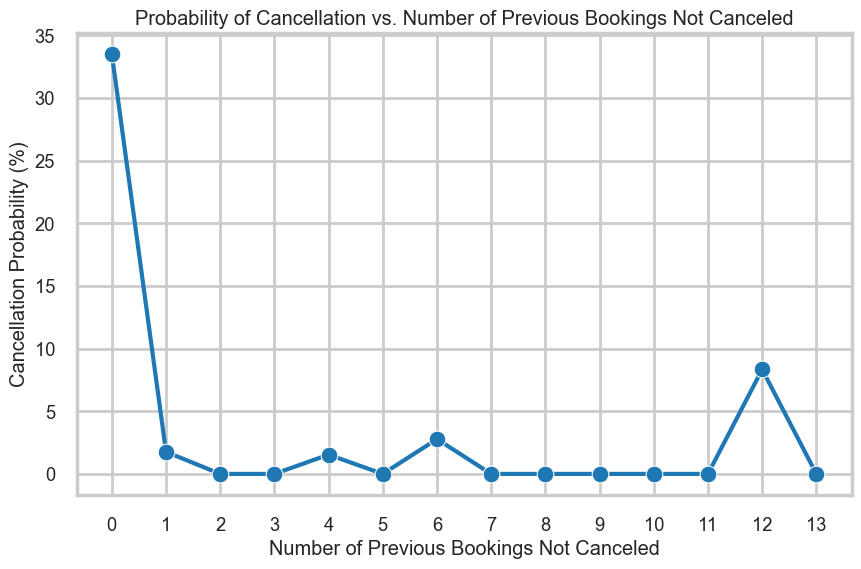

In [18]:
all_values = pd.DataFrame({'no_of_previous_bookings_not_canceled': range(14)})  
status_probability = df.groupby('no_of_previous_bookings_not_canceled')['booking_status'].value_counts(normalize=True).unstack().fillna(0)
status_probability = all_values.join(status_probability, on='no_of_previous_bookings_not_canceled').fillna(0)
status_probability['cancellation_probability'] = status_probability.get('canceled', 0) * 100
plt.figure(figsize=(10, 6))
sns.lineplot(data=status_probability, x='no_of_previous_bookings_not_canceled', y='cancellation_probability', marker='o')
plt.title('Probability of Cancellation vs. Number of Previous Bookings Not Canceled')
plt.xlabel('Number of Previous Bookings Not Canceled')
plt.ylabel('Cancellation Probability (%)')
plt.xticks(range(14)) 
plt.grid(True)
plt.show()


A high previous cancellation rate could indicate a higher cancellation probability.

### Number of Special Requests

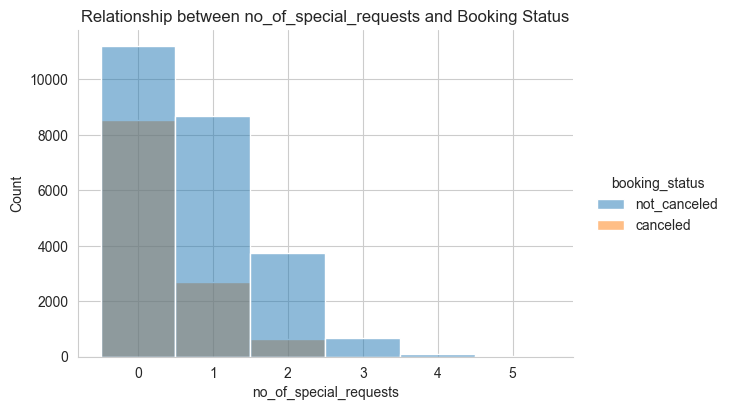

In [13]:
custom_displot('no_of_special_requests')

Bookings without special requests have a higher cancellation probability, while bookings with one or two special requests are more likely to be not canceled, indicating that guests with specific needs tend to commit to their bookings.

### Lead Time

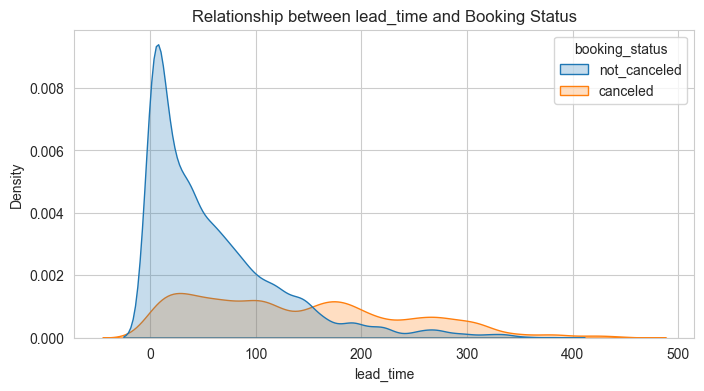

In [ ]:
custom_KDE('lead_time')

Bookings with shorter lead times tend to have lower cancellation rates, and the likelihood of cancellation increases as the lead time increases. 

The correlation between lead time and cancellation rates can be attributed to several factors::1. 

Customers who book closer to their arrival date often have more immediate and concrete plans, reducing the likelihood of canceling their reservati ns.
Conversely, bookings made far in advance may be more tentative, allowing for changes in plans or unforeseen circumstances that could lead to cancellati2. olicies:

Hotels often have more lenient cancellation policies for bookings made further in advance, allowing customers to cancel without penalty up to a ce tain point.
In contrast, bookings made closer to the arrival date may have stricter cancellation policies or require prepayment, discouraging ca3. vailability:

Availability of hotel rooms tends to decrease as the arrival date approaches, especially during peag -demand events.
Customers booking closer to their arrival date may face limited options or higher prices, incentivizing them to follow through with their reservations to securrdless of lead time.

### Average Price Per Room

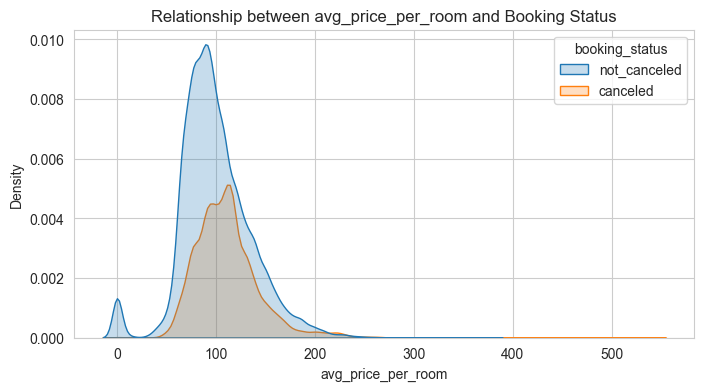

In [14]:
custom_KDE('avg_price_per_room')

Lower average room prices are associated with lower cancellation probabilites, while bookings are more likely to be canceled as the average room price increases.

### Summary of Significant Factors Increasing Cancellation Probability

The probability of cancellation is influenced by several key factors:

1. **Higher Weekend Nights** - Stays that include more weekend nights are more likely to be canceled.
2. **Longer Lead Time** - The longer the gap between booking and the stay, the higher the probability of cancellation.
3. **Bookings Made Between May - July** - Reservations made during these months show a higher cancellation rate.
4. **13 Previous Cancellations** - A history of 13 previous cancellations significantly increases the likelihood of future cancellations.
5. **No Special Requests** - Bookings with no special requests have a higher chance of being canceled.
6. **High Previous Cancellation Rate** - A high rate of previous cancellations is a strong predictor of future cancellations.


## Analyse Categorical Columns

In the analysis of the class based features, we will focus on using heatmap to understand the distribution of cancelled and not_cancelled

### Repeated guest

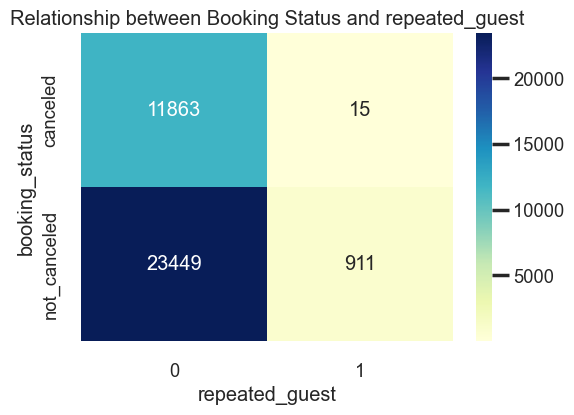

In [ ]:
custom_heatmap('repeated_guest')

Non-repeated guests are much more likely to cancel bookings compared to repeated guests, with the vast majority of non-canceled bookings being from non-repeated guests.

### Parking Space

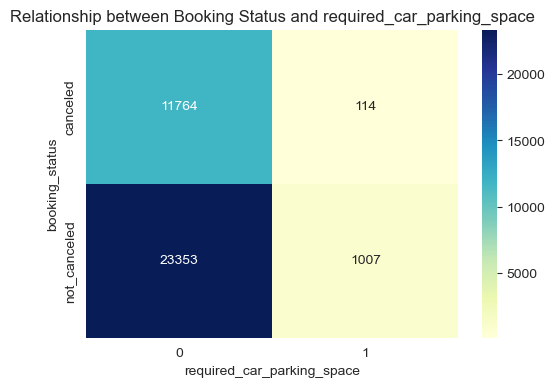

In [ ]:
custom_heatmap('required_car_parking_space')

The majority of bookings do not require a car parking space, and bookings without this requirement have a higher cancellation rate than those with it.

### Meal Plan

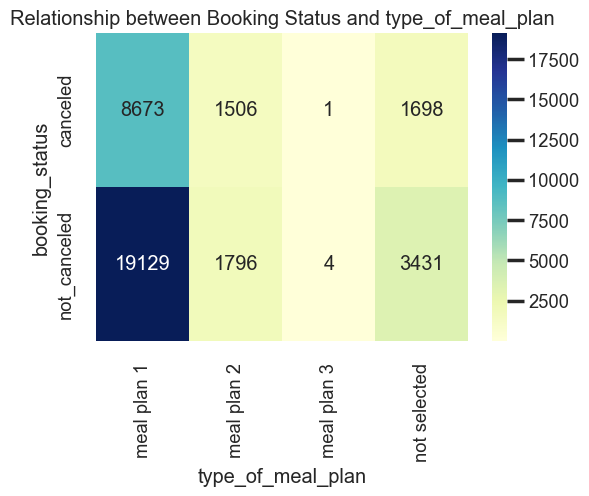

In [21]:
custom_heatmap('type_of_meal_plan')

In [22]:
# Calculation of probabilities
probabilities = df.groupby('type_of_meal_plan')['booking_status'].value_counts(normalize=True).unstack().fillna(0)
probabilities.columns = ['Probability Cancelled', 'Probability Not Cancelled']
print(probabilities)

                   Probability Cancelled  Probability Not Cancelled
type_of_meal_plan                                                  
meal plan 1                     0.311956                   0.688044
meal plan 2                     0.456087                   0.543913
meal plan 3                     0.200000                   0.800000
not selected                    0.331059                   0.668941


The choice of meal plan appears to significantly influence the likelihood of a booking being maintained, with varying cancellation rates correlating to different meal options. Notably when meal plan 2 is chosen, there is a higher relative probability of the booking being cancelled

### Room type

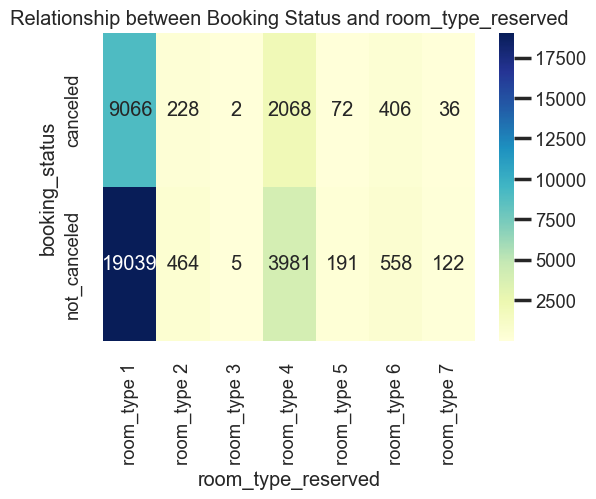

In [23]:
custom_heatmap('room_type_reserved')

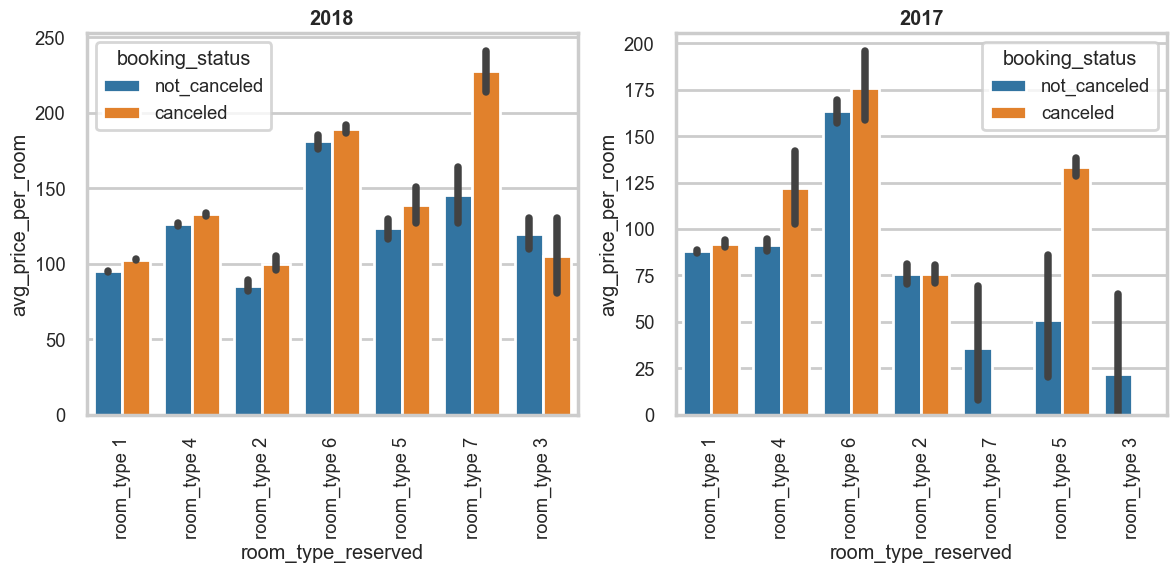

In [24]:
cols = df['arrival_year'].value_counts()

plt.figure(figsize=(12,10))
for i, col in enumerate(cols.index):
    ax = plt.subplot(2,2,i+1)
    sns.barplot(x='room_type_reserved', y='avg_price_per_room', 
                hue='booking_status',
                data=df[df['arrival_year'] == col])
    plt.title(col, fontweight='bold')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [25]:
# Calculation of probabilities
probabilities = df.groupby('room_type_reserved')['booking_status'].value_counts(normalize=True).unstack().fillna(0)
probabilities.columns = ['Probability Cancelled', 'Probability Not Cancelled']
print(probabilities)

                    Probability Cancelled  Probability Not Cancelled
room_type_reserved                                                  
room_type 1                      0.322576                   0.677424
room_type 2                      0.329480                   0.670520
room_type 3                      0.285714                   0.714286
room_type 4                      0.341875                   0.658125
room_type 5                      0.273764                   0.726236
room_type 6                      0.421162                   0.578838
room_type 7                      0.227848                   0.772152


While the probabilities will not be a good indicator at this current state in prediction due to an unbalanced dataset, it can be seen that room type 6 has a relatively higher probability of being cancelled.

Room types 1, 4, 5 and 6 generally has higher chance of cancellation. 

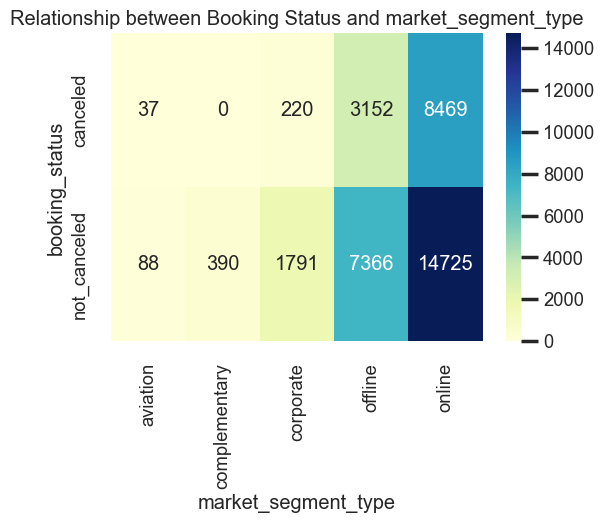

In [26]:
custom_heatmap('market_segment_type')

Market Segment type:
Online market_segment is more prominient and makes most no of booking and cancellations.
Offline's are the second best in terms of booking/cancel.

## Analyse Correlation between Features

We will explore to see which column features are highly correlated. Hence, we will only be able to measure a relation when the features vary numerically.

Highly correlated data can significantly affect model training by introducing multicollinearity, which can lead to inflated standard errors for the coefficients of the correlated variables and make the model unstable.

### Mutual Information between Categorical Features

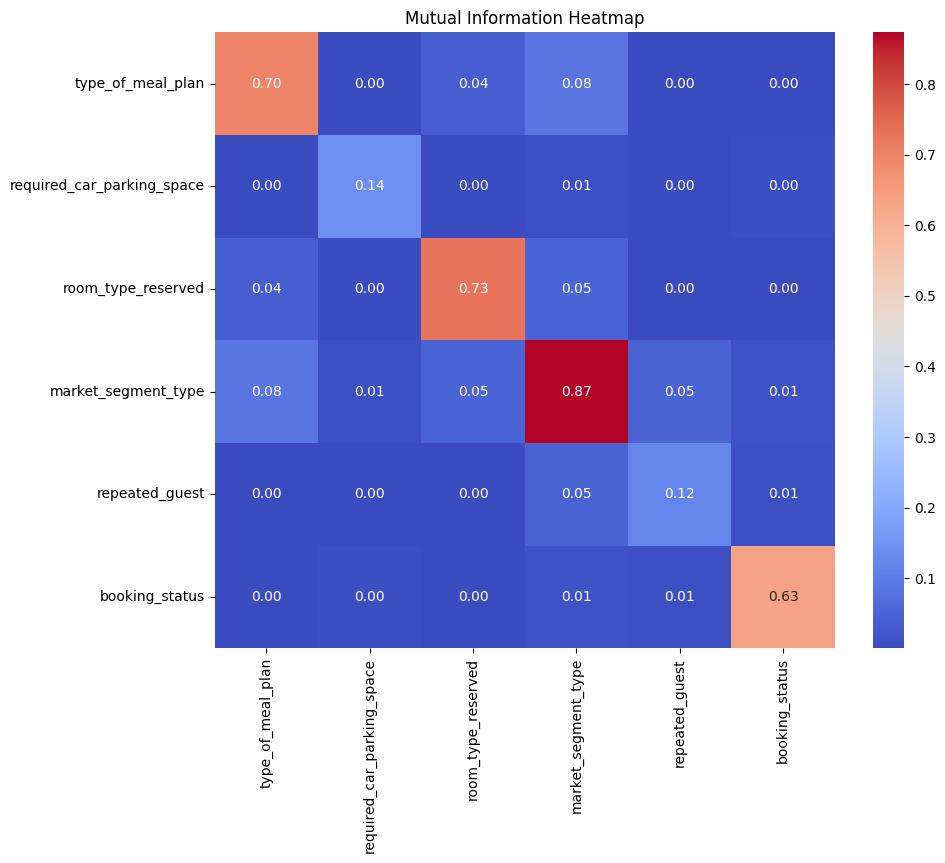

In [17]:
def calculate_mutual_info(df, col1, col2):
    return mutual_info_score(df[col1], df[col2])

# plot heatmap
mi_matrix = pd.DataFrame(index=cat_columns, columns=cat_columns)
for i in cat_columns:
    for j in cat_columns:
        mi_matrix.loc[i, j] = calculate_mutual_info(df, i, j)

plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(mi_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mutual Information Heatmap')
plt.show()

### Correlation between Numerical Features

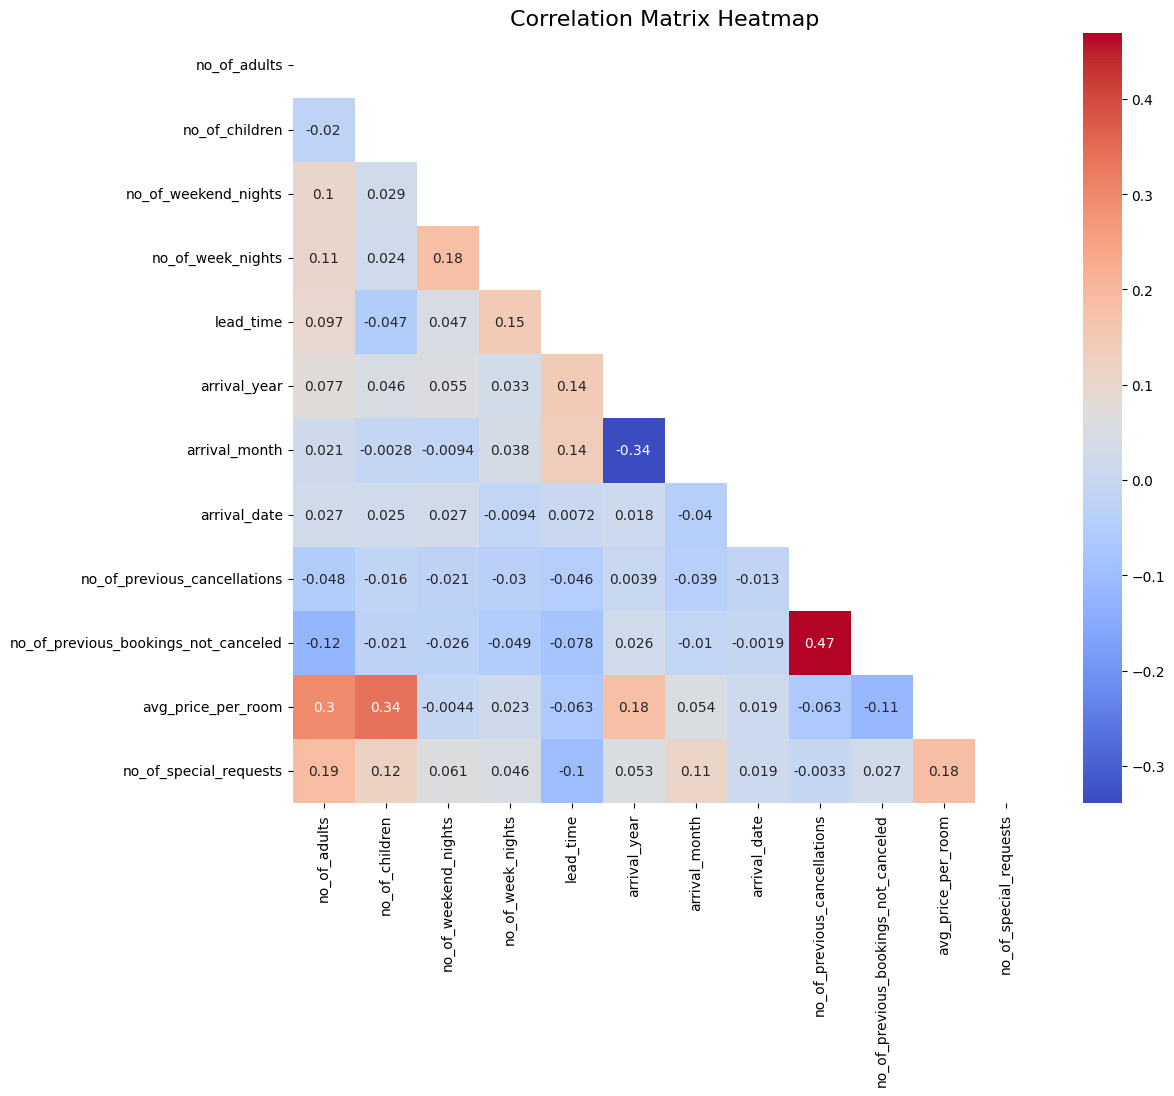

In [15]:
corr_matrix = df[num_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

### Correlation Analysis Summary

**Strong Negative Correlation (-0.47):** There is a strong negative correlation between the number of previous bookings not canceled and the number of previous cancellations. Guests who have a history of not canceling their bookings are less likely to have cancellations in the future, attributed to a reliable behavior among certain customers.

**Moderate Negative Correlation (-0.34):** The arrival month has a moderate negative correlation with the arrival year. This could be due to differnent 'peak seasons' in terms of bookings throughout the years

**Weak Positive Correlations (0.18 and 0.19):** The number of week nights shows a weak positive correlation with number of weekend nights, suggesting that longer planned stays might occur more on weekdays. The number of special requests has a similar weak positive correlation with the number of adults, indicating that bookings with more adults tend to have more special requests.


## Analyse Interactions between Features

### Relationship between Previous Bookings Not Canceled and Previous Cancellations

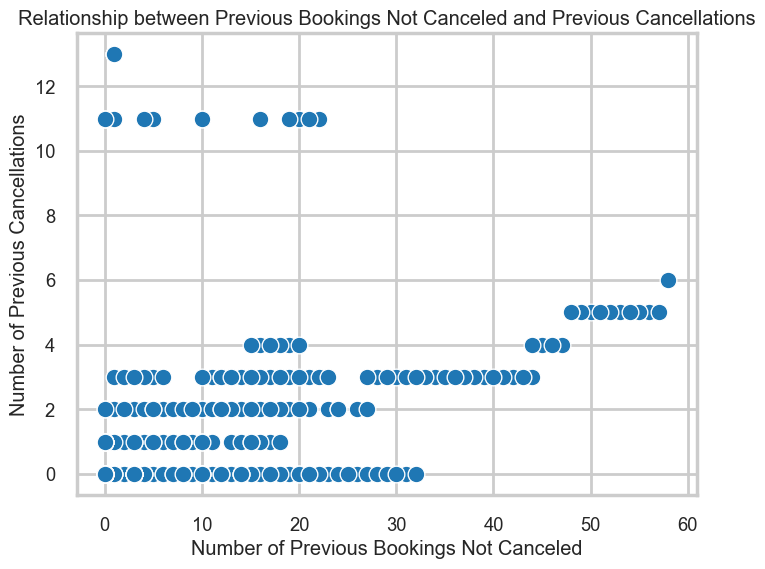

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='no_of_previous_bookings_not_canceled', y='no_of_previous_cancellations')
plt.title('Relationship between Previous Bookings Not Canceled and Previous Cancellations')
plt.xlabel('Number of Previous Bookings Not Canceled')
plt.ylabel('Number of Previous Cancellations')
plt.show()

Guests who have a higher history of not canceling their bookings are likely to have fewer previous cancellations. This pattern could be attributed to reliable behavior among certain customers or the hotel's policies for handling frequent cancellations. 

However, the presence of outliers and the non-linear relationship suggest that other factors may also influence the relationship between these two variables.

### Relationship between Arrival Month and Arrival Year

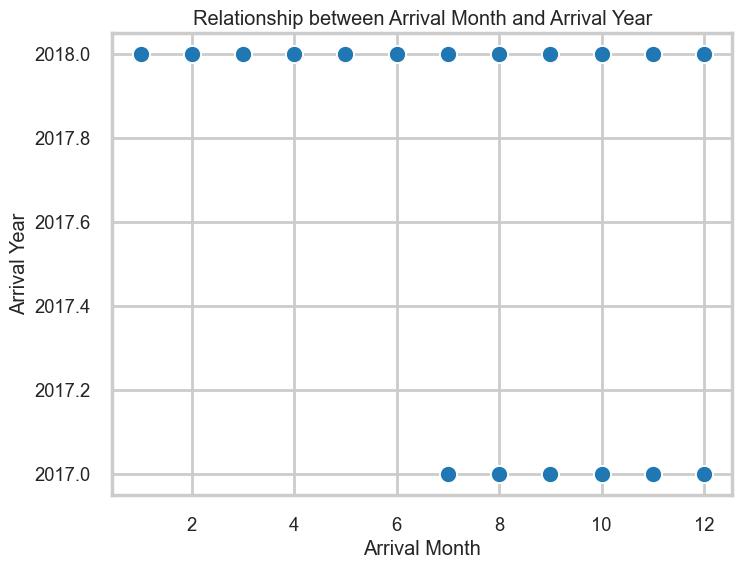

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='arrival_month', y='arrival_year')
plt.title('Relationship between Arrival Month and Arrival Year')
plt.xlabel('Arrival Month')
plt.ylabel('Arrival Year')
plt.show()

The negative correlation between arrival month and arrival year could potentially be attributed to different booking patterns or "peak seasons" across different years. However, as the dataset only contains 2 years of data, it is difficult to draw definitive conclusions.

Most likely, it could be that data was only collected between July 2017 and end 2018.

### Relationship between Number of Week Nights and Number of Weekend Nights

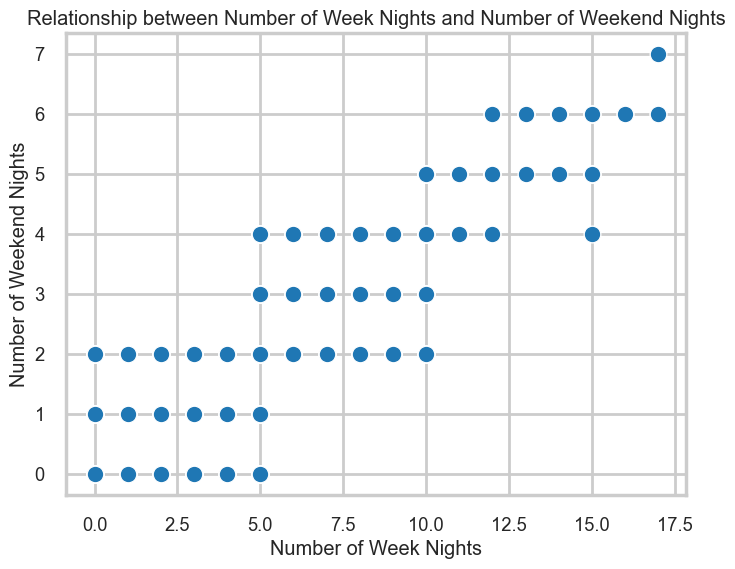

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='no_of_week_nights', y='no_of_weekend_nights')
plt.title('Relationship between Number of Week Nights and Number of Weekend Nights')
plt.xlabel('Number of Week Nights')
plt.ylabel('Number of Weekend Nights')
plt.show()

It is logical that as the number of week nights booked, the number of weekend nights booked increases due to increased likelihood of overlap over the weekend

### Relationship between Number of Special Requests and Number of Adults

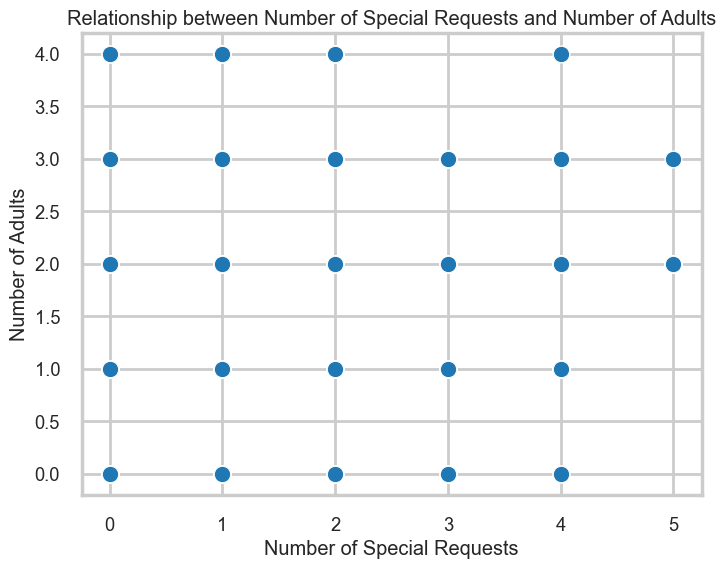

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='no_of_special_requests', y='no_of_adults')
plt.title('Relationship between Number of Special Requests and Number of Adults')
plt.xlabel('Number of Special Requests')
plt.ylabel('Number of Adults')
plt.show()

There is a generally weak positive trend, indicating that as the number of adults in a booking increases, the number of special requests also tends to increase.

## Next Steps

Now, after the data exploration stage,
for the next step, we will perform data preprocessing to process the data for classifcation.

## To Navigate To The Next Notebook:
0. [Introduction](/0%20-%20Introduction.ipynb) 
1. [Data Cleaning Notebook](/1%20-%20Data%20Cleaning.ipynb) 
2. [Exploratory Data Analyis Notebook](/2%20-%20Data%20Exploration.ipynb) - <b>[You Are Here Now]</b>
3. [Data Pre-processing Notebook](/3%20-%20Data%20Pre-Processing.ipynb)
4. [Initial Classification Models Notebook](/4%20-%20ClassificationModels.ipynb)
5. [Feature Engineering Notebook](/5%20-%20Feature%20Engineering.ipynb)
6. Applying Feature Selection + Hyperparameter Tuning On Individual Models
   1. [Logistic Regression Notebook](/6.1%20-%20Logistic%20Regression.ipynb)
   2. [K Nearest Neighbour Notebook](/6.2%20-%20K%20Nearest%20Neighbour.ipynb)
   3. [Decision Tree Notebook](/6.3%20-%20Decision%20Tree.ipynb)
   4. [Support Vector Machine Notebook](/6.4%20-%20SVM.ipynb)
   5. [Random Forest Notebook](/6.5%20-%20Random%20Forest.ipynb)
   6. [Adaboost Notebook](/6.6%20-%20Adaboost.ipynb)
   7. [Gradient Boost Notebook](/6.7%20-%20Gradient%20Boosting.ipynb)
   8. [LightGBM Notebook](/6.8%20-%20LightGBM.ipynb)
7.  [Final Model Comparisons + Conclusion Notebook](/7%20-%20Model%20Comparison,%20Final%20Model%20and%20Conclusion.ipynb)